In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score
import random

from sklearn.utils import resample

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import imdb
import tensorflow as tf

In [3]:
def imbalance_classes(X, y, imb_type='exp', imb_factor=0.01):
    np.random.seed(42)
    unique_classes = np.unique(y)
    num_classes = len(unique_classes)
    img_max = len(X) / num_classes

    img_num_per_cls = []
    if imb_type == 'exp':
        for cls_idx in range(num_classes):
            num = img_max * (imb_factor**(cls_idx / (num_classes - 1.0)))
            img_num_per_cls.append(int(num))
    elif imb_type == 'step':
        for cls_idx in range(num_classes // 2):
            img_num_per_cls.append(int(img_max))
        for cls_idx in range(num_classes // 2):
            img_num_per_cls.append(int(img_max * imb_factor))
    else:
        img_num_per_cls.extend([int(img_max)] * num_classes)

    X_imb, y_imb = [], []
    for cls, img_num in zip(unique_classes, img_num_per_cls):
        idx = np.random.choice(np.where(y == cls)[0], img_num, replace=False)
        X_imb.append(X[idx])
        y_imb.append(y[idx])

    X_imb = np.concatenate(X_imb)
    y_imb = np.concatenate(y_imb)

    return X_imb, y_imb

In [68]:
def load_imbalanced_cifar10_test(X_test, y_test, imbalance_type='exp', imbalance_ratio=0.01):
    X_test_imb, y_test_imb = imbalance_classes(X_test, y_test.flatten(), imbalance_type, imbalance_ratio)
    return X_test_imb, y_test_imb.flatten()

In [54]:
class UNet(nn.Module):
    def __init__(self, embedding_size=64):
        super(UNet, self).__init__()

        # Modified to accept 3-channel input
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Define the bottleneck part
        self.bottleneck_conv = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 8 * 8, embedding_size)  # Adjusted for CIFAR10 size after pooling

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = self.pool(x)
        x = F.relu(self.enc_conv2(x))
        x = self.pool(x)

        # Bottleneck
        x = F.relu(self.bottleneck_conv(x))
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [74]:
test_datasets = {}
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

unet = UNet()

def encode_dataset(dataset, model):
    dataset_tensor = torch.from_numpy(dataset).float().permute(0, 3, 1, 2)
    return unet(dataset_tensor).detach().numpy()

X_train = encode_dataset(X_train, model)

ratios = [1, 0.1, 0.01]
for ratio in ratios:
    X_test_imb, y_test_imb = load_imbalanced_cifar10_test(X_test, y_test, imbalance_ratio = ratio)
    X_test_imb = encode_dataset(X_test_imb, model)
    test_datasets[ratio] = (X_test_imb, y_test_imb)

In [61]:
class BiasedRandomForestClassifier(RandomForestClassifier):
    def __init__(self,
                 n_estimators=100,
                 criterion='gini',
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0,
                 max_features='sqrt',
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.0,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 random_state=None,
                 verbose=0,
                 warm_start=False,
                 class_weight=None,
                 ccp_alpha=0.0,
                 max_samples=None,
                n_classes = 10):

        super(BiasedRandomForestClassifier, self).__init__(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight,
            ccp_alpha=ccp_alpha,
            max_samples=max_samples)
        
        self.n_classes = n_classes
        self.thresholds = [1/self.n_classes for _ in range(self.n_classes)]

    def fit(self, X, y, sample_weight=None):
        return super(BiasedRandomForestClassifier, self).fit(X, y, sample_weight)

    def fit_thresholds(self, X, y, alpha = 0.01, batches = 50, sample_weight = None):
        X_batches = np.array_split(X, batches)
        y_batches = np.array_split(y, batches)
        cnt = 0
        for X_batch, y_batch in zip(X_batches, y_batches):
            cnt += 1
            y_pred = self.predict(X_batch)
            for y_p, y in zip(y_pred, y_batch):
                if y_p != y:
                    diff = alpha * self.thresholds[y]
                    self.thresholds[y_p] += diff
                    self.thresholds[y] -= diff
#             print('Batch No: ', cnt, '\nThresholds: ', self.thresholds)
        return self.thresholds

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba - self.thresholds, axis = 1)
    
    def predict_biased_label_shift(self, X, train_ratios, test_ratios):
        proba = self.predict_proba(X)
        for i in range(10):
            proba[:, i] *= test_ratios[i] / train_ratios[i]
        proba /= proba.sum(axis = 1, keepdims = True)
        return np.argmax(proba - self.thresholds, axis = 1)
    
    def predict_biased_online(self, X, y, alpha = 0.01):
        res = []
        threshold_history = []
        for (xi, yi) in zip(X, y):
            proba = self.predict_proba([xi])
            predicted_class = np.argmax(proba - self.thresholds, axis = 1)[0]
            res.append(predicted_class)

            threshold_history.append(self.thresholds.copy()) 

            if predicted_class != yi:
                diff = alpha * self.thresholds[yi]
                self.thresholds[predicted_class] += diff
                self.thresholds[yi] -= diff
        return np.array(res), threshold_history
    
    def reset_thresholds(self):
        self.thresholds = [1/self.n_classes for _ in range(self.n_classes)]

In [73]:
model = BiasedRandomForestClassifier()
model.fit(X_train, y_train)
og = RandomForestClassifier()
og.fit(X_train, y_train)

/Users/fxh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/fxh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [75]:
def evaluate_models_online(test_datasets, model, og):
    # Prepare the test data
    
    accuracies = []
    precisions = []
    recalls = []
    ratios = []
    og_accuracies = []
    og_precisions = []
    og_recalls = []
    
    histories = {}
    

    for ratio, test_dataset in test_datasets.items():
        print('Test Bias Ratio: ', ratio)
        #print('Fitted thresholds: ', thresholds)
        
        X_test, y_test = test_dataset
        model.reset_thresholds()
        predictions, history = model.predict_biased_online(X_test, y_test, alpha = 0.1)
        histories[ratio] = history
        accuracies.append(accuracy_score(y_test, predictions))
        og_accuracies.append(accuracy_score(y_test, og.predict(X_test)))
        og_precisions.append(precision_score(y_test, og.predict(X_test), average='macro'))
        og_recalls.append(recall_score(y_test, og.predict(X_test), average='macro'))
        precisions.append(precision_score(y_test, predictions, average='macro'))
        recalls.append(recall_score(y_test, predictions, average='macro'))
        ratios.append(ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_accuracies, label='RF Accuracy', color='blue')
    plt.plot(ratios, accuracies, label='DeBOT Accuracy', color='red')

    plt.xlabel('Imbalance Ratio')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_precisions, label='RF Precision', color='blue')
    plt.plot(ratios, precisions, label='DeBOT Precision', color='red')

    plt.xlabel('Imbalance Ratio')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_recalls, label='RF Recall', color='blue')
    plt.plot(ratios, recalls, label='DeBOT Recall', color='red')

    plt.xlabel('Imbalance Ratio')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    return histories

Test Bias Ratio:  1


/Users/fxh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Bias Ratio:  0.1


/Users/fxh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Bias Ratio:  0.01


/Users/fxh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


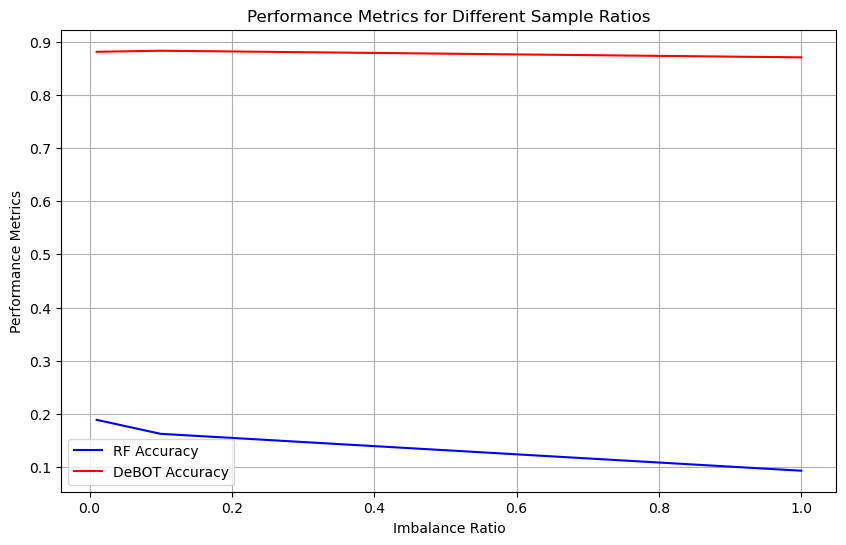

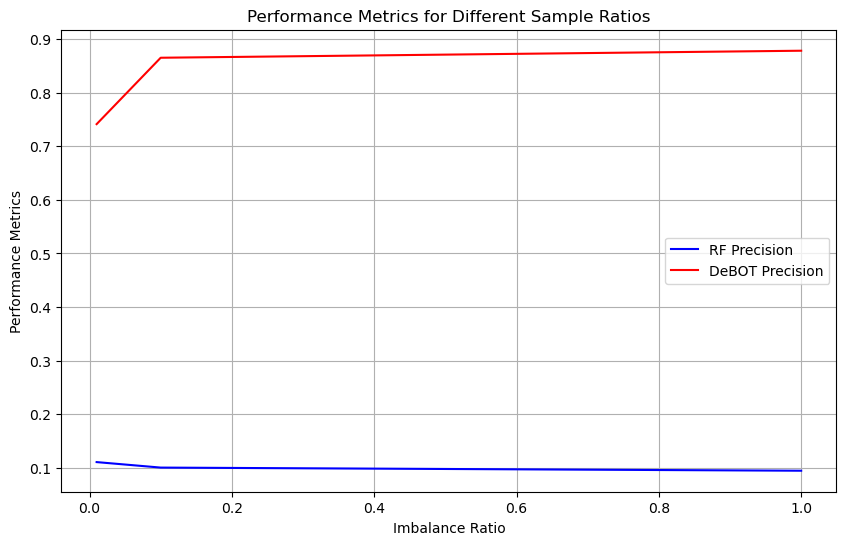

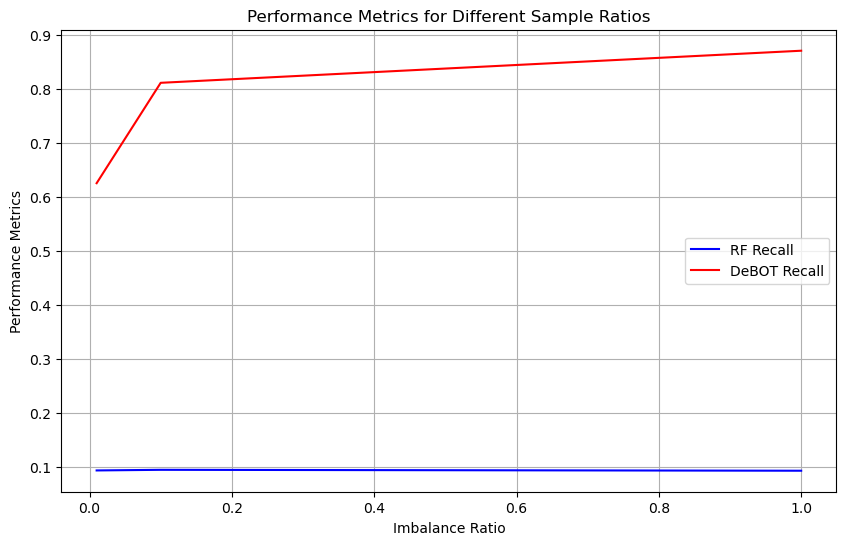

In [76]:
histories = evaluate_models_online(test_datasets, model, og)